## Now Casting IPCA 
1 month ahead IPCA forecasting with exogenous variables and cross validation

In [1]:
import os
import gc

os.chdir('../../')

In [21]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import lightgbm as lgb
from scipy.signal import periodogram, detrend

from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import shap 

from typing import Optional,Dict,Tuple
from pathlib import Path

from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, LocalStandardScaler

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mae, coverage, mase

from mlforecast.feature_engineering import transform_exog
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from utilsforecast.feature_engineering import future_exog_to_historic

from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, AutoDifferences, LocalBoxCox, GlobalSklearnTransformer
from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

import os

from sklearn.preprocessing import FunctionTransformer
sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# plots setup
# https://medium.com/@tttgm/styling-charts-in-seaborn-92136331a541
plt.rcParams.update(**{'figure.dpi': 150})
# color palette can be passed as a list of hex codes
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# set overall plot style, font size scaling factor, and color palette
sns.set(style="whitegrid", font_scale=1, palette=custom_colors)
warnings.filterwarnings("ignore", "use_inf_as_na") # issue with seaborn

## Reading and preprocessing the data

In [63]:
## Read the week_3/data/raw/inflation.csv
df_original= pd.read_csv('week_3/data/raw/inflation.csv')

df_original['ds'] = pd.to_datetime(df_original['Date'])
df_original = df_original[(df_original.ds >= '2004-01-01') & (df_original.ds < '2025-01-01')]
df_original['unique_id'] = 1
df_original['y'] = df_original['IPCA']
df = df_original.copy()

In [64]:
df_original

,Date,IPCA,IGPM,INPC,IPC-Fipe,CDI,ds,unique_id,y
24,2004-01-01,0.76,0.88,0.83,0.65,1.26,2004-01-01,1,0.76
25,2004-02-01,0.61,0.69,0.39,0.19,1.08,2004-02-01,1,0.61
26,2004-03-01,0.47,1.13,0.57,0.12,1.37,2004-03-01,1,0.47
27,2004-04-01,0.37,1.21,0.41,0.29,1.17,2004-04-01,1,0.37
28,2004-05-01,0.51,1.31,0.40,0.57,1.22,2004-05-01,1,0.51
...,...,...,...,...,...,...,...,...,...
271,2024-08-01,-0.02,0.29,-0.14,0.18,0.87,2024-08-01,1,-0.02
272,2024-09-01,0.44,0.62,0.48,0.18,0.84,2024-09-01,1,0.44
273,2024-10-01,0.56,1.52,0.61,0.80,0.93,2024-10-01,1,0.56
274,2024-11-01,0.39,1.30,0.33,1.17,0.79,2024-11-01,1,0.39


In [65]:
# Getting exogenous variables
df_exg = df_original[['unique_id', 'ds', 'IPC-Fipe', 'CDI']].copy()

# Get difference (1st order) of the series CDI
df_exg['CDI_diff'] = df_exg['CDI'].diff(1)

#drop original CDI column
df_exg.drop(columns=['CDI'], inplace=True)

In [66]:
# Preprocessing dataframe to Nixtla format
df = df[['unique_id', 'ds', 'y']]
df.head()

,unique_id,ds,y
24,1,2004-01-01,0.76
25,1,2004-02-01,0.61
26,1,2004-03-01,0.47
27,1,2004-04-01,0.37
28,1,2004-05-01,0.51


In [67]:
df_exg.columns

Index(['unique_id', 'ds', 'IPC-Fipe', 'CDI_diff'], dtype='object')

## Pre-processing Exogenous variables

In [84]:
df_exg_processed, future_df = future_exog_to_historic(df_exg, freq='MS', features=['CDI_diff', 'IPC-Fipe'], h=1)
df_exg_processed

,unique_id,ds,CDI_diff,IPC-Fipe
0,1,2004-01-01,NaN,NaN
1,1,2004-02-01,NaN,0.65
2,1,2004-03-01,-0.18,0.19
3,1,2004-04-01,0.29,0.12
4,1,2004-05-01,-0.20,0.29
...,...,...,...,...
247,1,2024-08-01,0.12,0.06
248,1,2024-09-01,-0.04,0.18
249,1,2024-10-01,-0.03,0.18
250,1,2024-11-01,0.09,0.80


In [85]:
df_exg_processed = transform_exog(df_exg_processed, lags=[1, 3, 6, 12])

In [70]:
df_final = df.merge(df_exg_processed, on=['unique_id', 'ds'], how='left')

In [89]:
df_final = df_final.interpolate(method='linear', limit_direction='both')

In [90]:
df_final

,unique_id,ds,y,CDI_diff,IPC-Fipe,CDI_diff_lag1,CDI_diff_lag3,CDI_diff_lag6,CDI_diff_lag12,IPC-Fipe_lag1,IPC-Fipe_lag3,IPC-Fipe_lag6,IPC-Fipe_lag12
0,1,2004-01-01,0.76,-0.18,0.65,-0.18,-0.18,-0.18,-0.18,0.65,0.65,0.65,0.65
1,1,2004-02-01,0.61,-0.18,0.65,-0.18,-0.18,-0.18,-0.18,0.65,0.65,0.65,0.65
2,1,2004-03-01,0.47,-0.18,0.19,-0.18,-0.18,-0.18,-0.18,0.65,0.65,0.65,0.65
3,1,2004-04-01,0.37,0.29,0.12,-0.18,-0.18,-0.18,-0.18,0.19,0.65,0.65,0.65
4,1,2004-05-01,0.51,-0.20,0.29,0.29,-0.18,-0.18,-0.18,0.12,0.65,0.65,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1,2024-08-01,-0.02,0.12,0.06,-0.04,0.06,0.08,0.00,0.26,0.33,0.46,-0.14
248,1,2024-09-01,0.44,-0.04,0.18,0.12,-0.06,-0.17,0.07,0.06,0.09,0.46,-0.20
249,1,2024-10-01,0.56,-0.03,0.18,-0.04,-0.04,0.03,-0.17,0.18,0.26,0.26,0.29
250,1,2024-11-01,0.39,0.09,0.80,-0.03,0.12,0.06,0.03,0.18,0.06,0.33,0.30


## Define the model and run Crossvalidation
https://nixtlaverse.nixtla.io/statsforecast/docs/tutorials/crossvalidation.html

In [93]:
## Train the model
models  = [
    CatBoostRegressor(n_estimators=200, random_state=42, verbose=False),    
    LinearRegression(),
    lgb.LGBMRegressor(n_estimators=200, random_state=42, verbose=-1),
]
fcst = MLForecast(
    models=models,
    freq='MS',  # our serie has a monthly frequency
    lags=[12, 6, 3, 1],
    
    lag_transforms={
        1: [
            ExpandingMean(),
            RollingMean(window_size=3),
            RollingMean(window_size=6),
            RollingMean(window_size=12),
            RollingStd(window_size=3),
            RollingStd(window_size=6),
            RollingStd(window_size=12),
        ],
        3: [
            ExpandingMean(),
        ],
    },
    date_features=['month', 'quarter'], 
)

In [125]:
cv_df = fcst.cross_validation(
    df=df_final,
    h=1,
    n_windows=24,
    level=[50,90],
    static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=12, h=1, method="conformal_distribution")
)

In [126]:
cv_df.tail(10)

,unique_id,ds,cutoff,y,CatBoostRegressor,LinearRegression,LGBMRegressor,CatBoostRegressor-lo-90,CatBoostRegressor-lo-50,CatBoostRegressor-hi-50,CatBoostRegressor-hi-90,LinearRegression-lo-90,LinearRegression-lo-50,LinearRegression-hi-50,LinearRegression-hi-90,LGBMRegressor-lo-90,LGBMRegressor-lo-50,LGBMRegressor-hi-50,LGBMRegressor-hi-90
14,1,2024-03-01,2024-02-01,0.16,0.731472,0.646408,0.824419,0.555375,0.621174,0.841770,0.907569,0.366543,0.525449,0.767367,0.926272,0.491922,0.715908,0.932930,1.156916
15,1,2024-04-01,2024-03-01,0.38,0.177040,0.124069,0.145128,-0.206849,0.100693,0.253386,0.560928,-0.200760,-0.049695,0.297833,0.448898,-0.269886,0.012290,0.277966,0.560141
16,1,2024-05-01,2024-04-01,0.46,0.430765,0.333577,0.484696,0.063391,0.307623,0.553906,0.798139,-0.003503,0.120732,0.546421,0.670656,0.101743,0.375413,0.593979,0.867649
17,1,2024-06-01,2024-05-01,0.21,0.244008,0.189032,0.336652,-0.094737,0.182989,0.305027,0.582753,-0.140195,0.018610,0.359453,0.518258,-0.054539,0.230738,0.442566,0.727843
18,1,2024-07-01,2024-06-01,0.38,0.286539,0.243208,0.168168,-0.110568,0.188243,0.384835,0.683647,-0.042958,0.123719,0.362697,0.529375,-0.269292,0.036768,0.299568,0.605628
19,1,2024-08-01,2024-07-01,-0.02,0.236134,0.364217,0.262148,-0.162242,0.133747,0.338520,0.634510,0.078688,0.219870,0.508563,0.649746,-0.097433,0.079651,0.444646,0.621729
20,1,2024-09-01,2024-08-01,0.44,0.342228,0.221571,0.309522,-0.046626,0.244354,0.440102,0.731082,-0.159478,0.079983,0.363159,0.602620,-0.130219,0.127188,0.491856,0.749264
21,1,2024-10-01,2024-09-01,0.56,0.382548,0.336198,0.441246,-0.004444,0.282022,0.483073,0.769539,-0.045358,0.163024,0.509372,0.717753,0.048346,0.289163,0.593330,0.834147
22,1,2024-11-01,2024-10-01,0.39,0.587361,0.593619,0.557037,0.225983,0.475965,0.698758,0.948740,0.216523,0.422021,0.765217,0.970714,0.215612,0.433743,0.680330,0.898461
23,1,2024-12-01,2024-11-01,0.52,0.730036,0.809703,0.676205,0.371407,0.565812,0.894260,1.088666,0.429879,0.610782,1.008623,1.189526,0.264629,0.529793,0.822616,1.087780


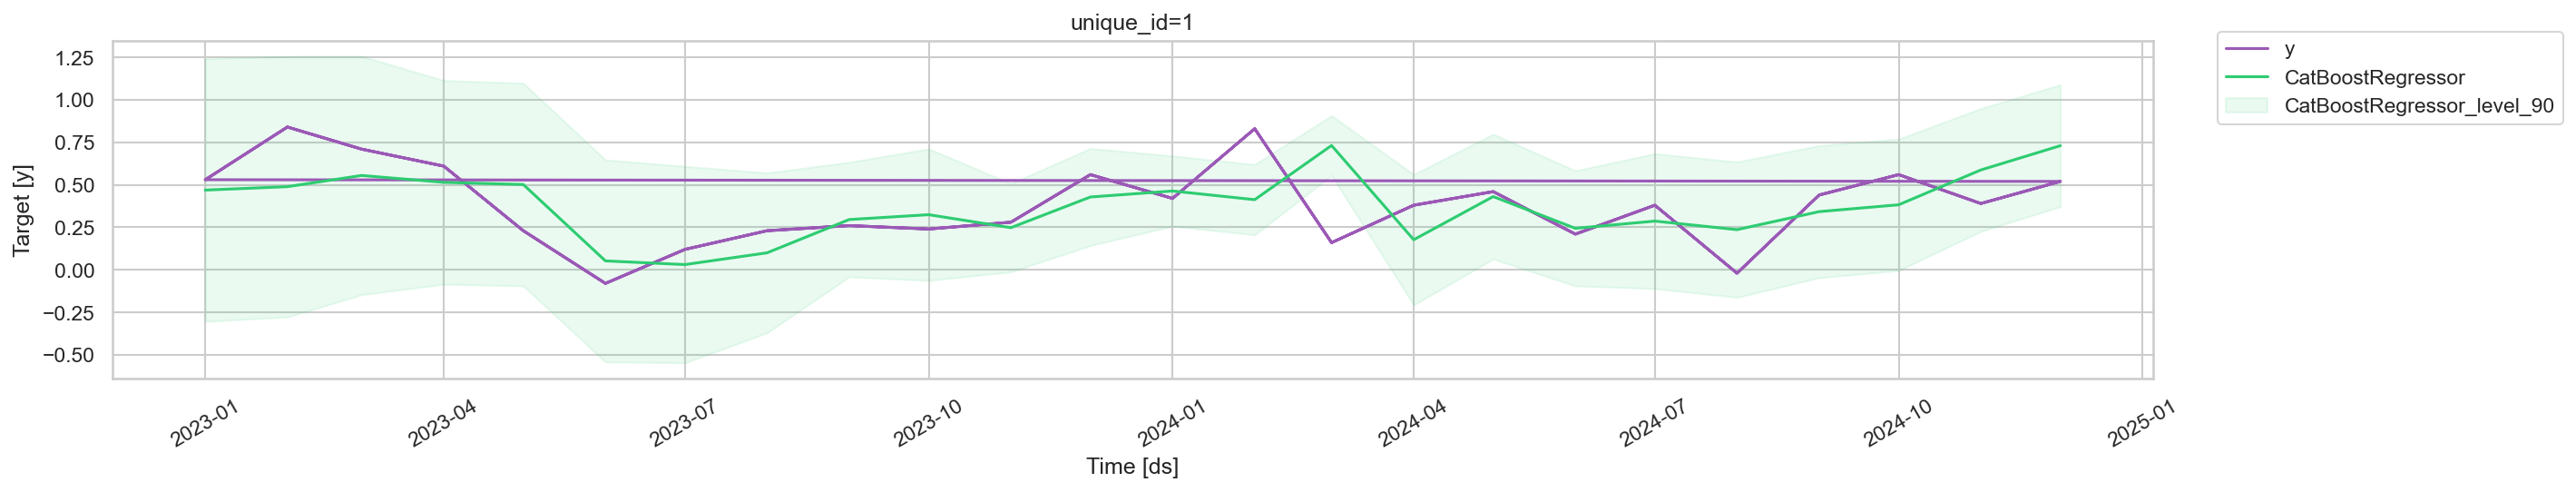

In [132]:
# Plot the model forecasting
fig = plot_series(
    cv_df, 
    cv_df, 
    plot_random=False, 
    level=[90],
    max_insample_length=2000,
    models=['CatBoostRegressor'],
)
fig

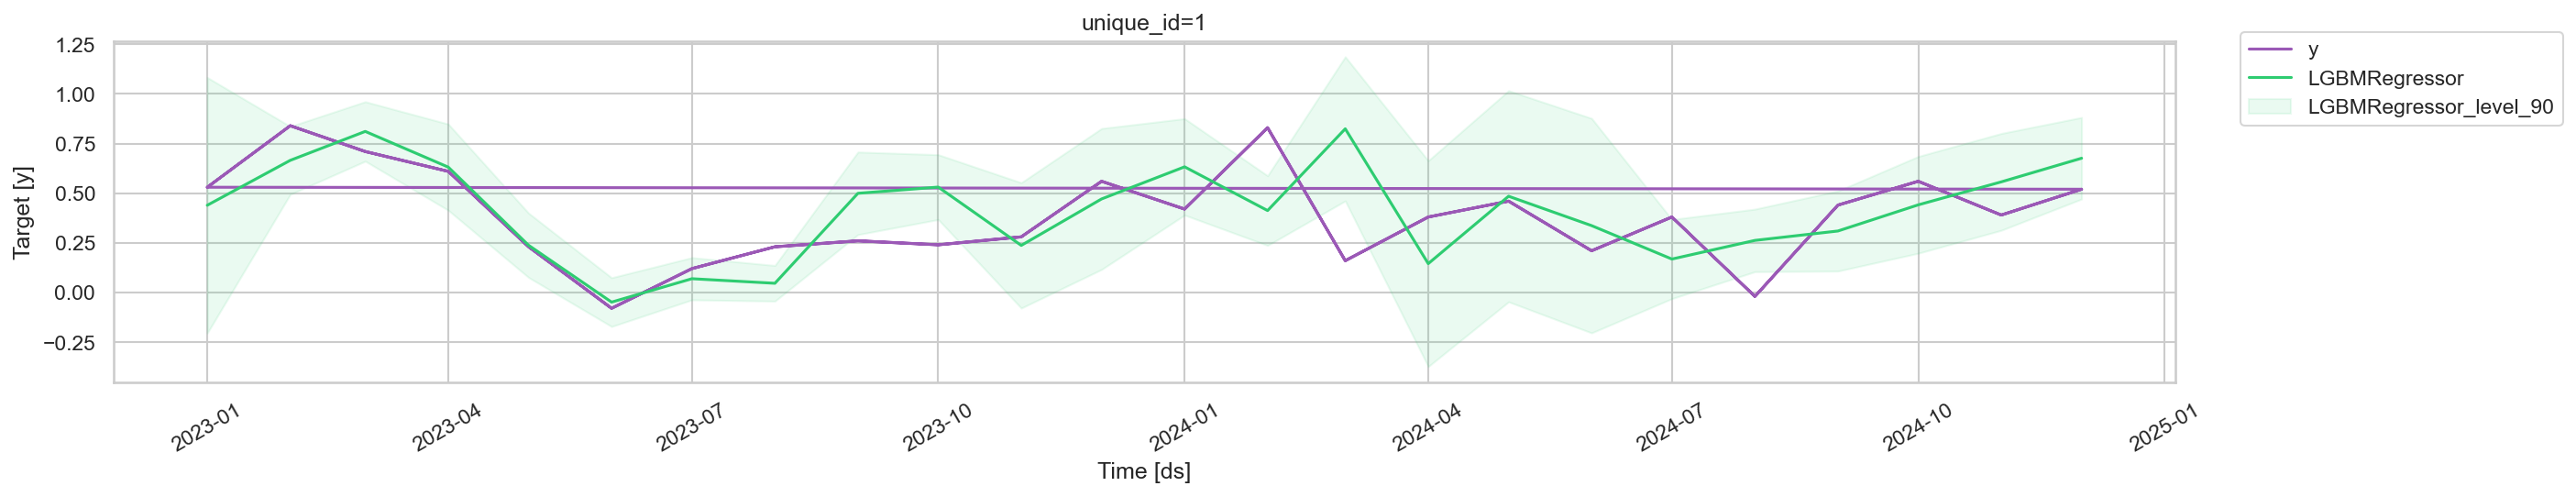

In [118]:
# Plot the model forecasting
fig = plot_series(
    cv_df, 
    cv_df, 
    plot_random=False, 
    level=[90],
    max_insample_length=2000,
    models=['LGBMRegressor'],
)
fig

In [128]:
cv_eval = evaluate(
    cv_df[(cv_df.ds >= '2024-01-01') & (cv_df.ds <= '2025-01-01')].drop(columns='cutoff'),
    metrics=[mape, mae, coverage],
    level=[90]
)
cv_eval

,unique_id,metric,CatBoostRegressor,LinearRegression,LGBMRegressor
0,1,mape,1.619978,2.183255,1.861626
1,1,mae,0.194243,0.227582,0.228955
2,1,coverage_level90,0.833333,0.750000,0.833333


# SHAP values

In [129]:
fcst.fit(df_final, static_features=[],  prediction_intervals=PredictionIntervals(n_windows=12, h=1, method="conformal_distribution"))

MLForecast(models=[CatBoostRegressor, LinearRegression, LGBMRegressor], freq=MS, lag_features=['lag12', 'lag6', 'lag3', 'lag1', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'rolling_mean_lag1_window_size12', 'rolling_std_lag1_window_size3', 'rolling_std_lag1_window_size6', 'rolling_std_lag1_window_size12', 'expanding_mean_lag3'], date_features=['month', 'quarter'], num_threads=1)

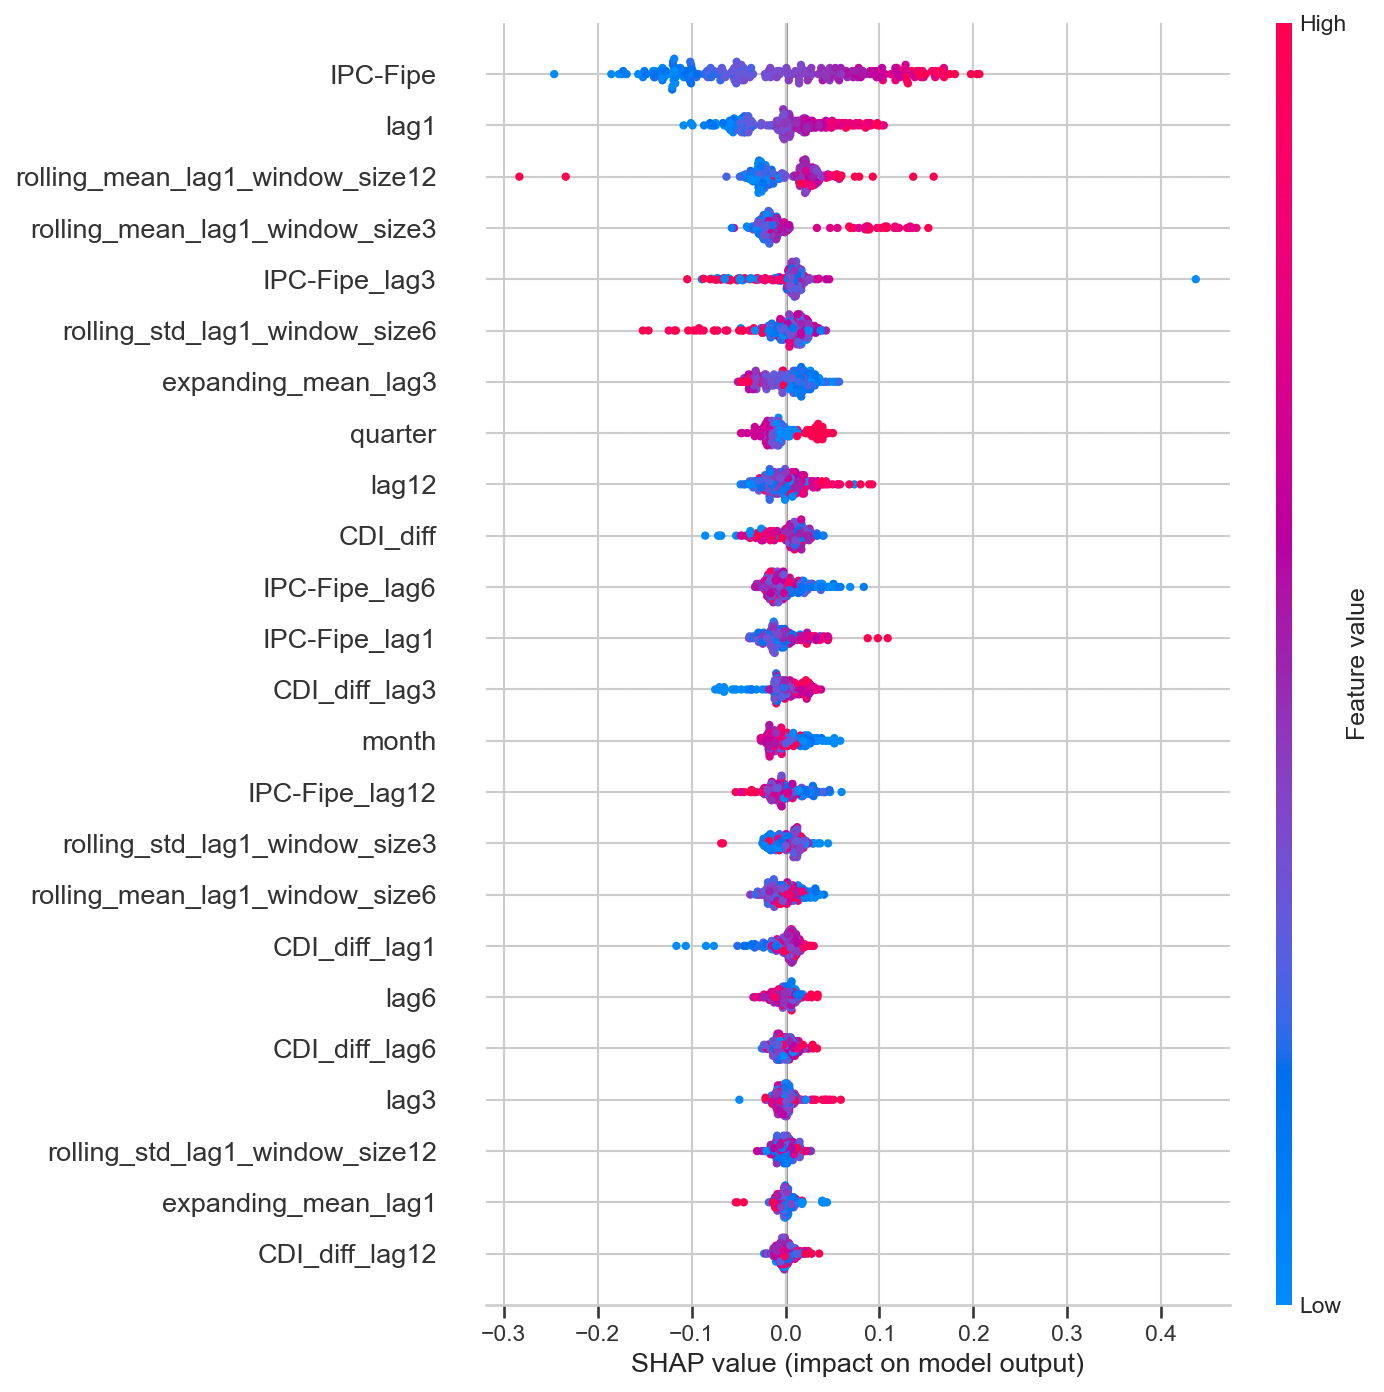

In [130]:
# pre-proc the df_train
df_final_prep, _ = fcst.preprocess(df_final, static_features=[], return_X_y=True)

# Get the catboost model
model = fcst.models_['CatBoostRegressor']

# Getting the SHAP values from the LGBM model
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_final_prep)
shap.plots.beeswarm(shap_values, max_display=25)